(probabilistic_networks)=
# Creating and manipulating networks of probabilistic nodes

## Representing probabilistic networks

Under the hood, [pyhgf](https://ilabcode.github.io/pyhgf/index.html#) is designed as a graph neural network library that manipulates networks of probabilistic node and performs beliefs propagation using dedicated variational message passing. Using this framework, any form of generalized Hierarchical Gaussian Filter can be fully determined by the following variables. Let 

$$\mathcal{HGF}_{k} = \{\chi, \xi, \mathcal{F}, \Sigma \}$$ 

be the HGF model with $K$ probabilistic nodes with 

$$\chi = \{\chi_1, ..., \chi_{k}\}$$ 

the set of node parameters. Nodes' parameters can be used to register sufficient statistics of the distributions as well as various coupling weights. The *shape* of the hierarchical structure is defined by the [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list)

$$\xi = \{\xi_1, ..., \xi_{k} \}$$, 

where every edge $\xi_k$ contains $m$ sets of node indexes, $m$ being the adjacency dimension (here we only consider value and volatility coupling, therefore $m=2$). The propagation of precision-weighted prediction error under new observations (or other generic belief propagation dynamics) are defined by the set of $n$ update functions

$$\mathcal{F} = \{f_1, ..., f_n\}$$

Each update function is parametrized by a node index $n \in 1, ..., k$ and the current state of the HGF model at time $t$. The most standard uses of the HGF only require continuous and/or binary update functions for input and states node. The propagation dynamics (the direction of the information flow) are controlled by the ordered update sequence

$$\Sigma = [f_1(n_1), ..., f_i(n_j), f \in \mathcal{F}, n \in 1, ..., k ]$$,

Each item of this sequence pairs a node index with an update function as previously defined.

![png](../images/graph_network.svg)

## Implementation details

Networks are represented by two variables and two sets of functions:

1. a dictionary `parameter structure` that registers the nodes' parameters.
2. a named tuple `node structure` that encodes the [adjacency list](https://en.wikipedia.org/wiki/Adjacency_list) (see {ref}`pyhgf.typing.Indexes.`).
2. updates functions (see e.g. the {ref}`pyhgf.continuous.` and {ref}`pyhgf.continuous.` modules)
4. an update sequence as a tuple of function/index pairs.

```{tip}
`node_structure` should be static arguments to update functions.
```

## Creating nodes

In [1]:
from pyhgf.typing import Indexes
parameters = {"mu": 0.0, "pi": 1.0}

parameters_structure = (parameters, parameters, parameters)
node_structure = (
    Indexes((1,), None),
    Indexes(None, (2,)),
    Indexes(None, None),
)

The code above illustrate the creation of a probabilistic network of 3 nodes with simple parameters sets $(\mu=0.0, \pi=1.0)$. Node 2 is the value parent of node 1. Node 3 is the value parent of node 2 and has no parents.

## Visualizing the network

Creating a continuous Hierarchical Gaussian Filter with 3 levels.


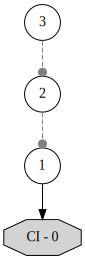

In [2]:
from pyhgf.model import HGF

# create a three-level HGF using default parameters
hgf = HGF(n_levels=3, model_type="continuous")
hgf.plot_network()

## Building a custom node structure
The two and three-level continuous and binary HGF are special cases of probabilistic networks that can be manipulated by pyhgf. We can indeed build probabilistic networks with arbitrary structure. Notably,
- one node can have multiple parents and/or children, both in the value and volatility domains.
- the network can have multiple input node, binary and/or continuous.

For example, the following network is a valid HGF structure:

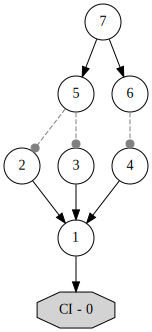

In [3]:
custom_hgf = (
    HGF(n_levels=3, model_type=None)
    .add_input_node(kind="continuous")
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[1])
    .add_volatility_parent(children_idxs=[2, 3])
    .add_volatility_parent(children_idxs=[4])
    .add_value_parent(children_idxs=[5, 6])
)
custom_hgf.plot_network()

It is also possible to work with multiple input:

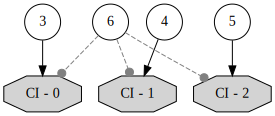

In [4]:
custom_hgf = (
    HGF(model_type=None)
    .add_input_node(kind="continuous", input_idx=0)
    .add_input_node(kind="continuous", input_idx=1)
    .add_input_node(kind="continuous", input_idx=2)
    .add_value_parent(children_idxs=[0])
    .add_value_parent(children_idxs=[1])
    .add_value_parent(children_idxs=[2])
    .add_volatility_parent(children_idxs=[0, 1, 2])
)
custom_hgf.plot_network()

The parameters structure and node structures are embedded in the HGF class anc can be retrieved with:

In [5]:
# paramter values from the first node
custom_hgf.parameters_structure[0]

{'kappas': (1.0,),
 'omega': -9.210340371976182,
 'time_step': nan,
 'value': nan,
 'psis': (1.0,)}

In [6]:
# the node structure
custom_hgf.node_structure

(Indexes(value_parents=(3,), volatility_parents=(6,)),
 Indexes(value_parents=(4,), volatility_parents=(6,)),
 Indexes(value_parents=(5,), volatility_parents=(6,)),
 Indexes(value_parents=None, volatility_parents=None),
 Indexes(value_parents=None, volatility_parents=None),
 Indexes(value_parents=None, volatility_parents=None),
 Indexes(value_parents=None, volatility_parents=None))

## Building custom update functions and sequences

Models that are created with parameter structures and node structures only represent static configuration of the HGF, they are not yet filtering new observation or acting in response to specific input. To add a dynamic and responsive layer, we need two additional components:

- update functions
- update sequences

Update functions are the heart of the HGF filtering procedure, these functions implement the message passing and parameters updating steps between node. An update function in its simplier form is a fuction defined as

```python
parameters_structure = update_fn(node_idx=i, parameters_structure, node_structure)
```

In other words, it is updating the parameters structure by applying certain transformation starting at node $i$. The function has acess top the entire parameters and nodes structure, which mean that it can retrive parameters from parents, children, grand-parents etc... Usually, pessage passing updates only use information found in the [Markov blanket](https://en.wikipedia.org/wiki/Markov_blanket) of the given node.